In [1]:
# imports

from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn import Client
from obspy import Stream
from obspy.signal.util import next_pow_2
from obspy.geodetics import gps2dist_azimuth
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# set up

# Example  (Hawaii HV, 2018):
CENTER_LAT, CENTER_LON = 19.3, -155.5
STARTTIME = "2014-05-01T00:00:00"
ENDTIME   = "2016-12-31T23:59:59"

# Search radius (degrees) for HV stations around the center:
MAXRADIUS_DEG = 10.0

# Prefer inter-station distances in this range (km) for microseism band:
MIN_DIST_KM, MAX_DIST_KM = 100.0, 400.0

# Band of interest (volcano):
FREQMIN = 0.5   # Hz  (20 s)
FREQMAX = 10.0   # Hz  (5 s)

# Windowing and correlation
WINDOW_LENGTH = 24 * 3600     # seconds (one-day windows)
DEFAULT_MAX_LAG = 300         # seconds; will auto-bump based on pair distance
TIME_NORMALIZATION = "onebit" # "onebit", "ram", or None
RAM_WINDOW_SEC = 10

# Response removal (to velocity)
# PRE_FILT = (0.005, 0.006, 45.0, 50.0)
# WATER_LEVEL = 60

# creates a client that connects to the IRIS data center
client = Client("IRIS")


In [3]:
# fetch data
def fetch_stream(net, sta, loc, cha, t0, t1, client_name="IRIS", attach_resp=True):
    client = Client(client_name)
    st = client.get_waveforms(net, sta, loc, cha, t0, t1, attach_response = attach_resp)
    st.merge(fill_value="interpolate")
    return st

In [14]:
# Input station information

freqmin = 0.5   # Hz  (20 s)
freqmax = 10.0   # Hz  (5 s)

stt = UTCDateTime("2014-10-01T03:35:40")
edt = UTCDateTime("2014-10-01T03:35:43")

# network
net = 'XD'
# station
sta = 'ME02'
# location
loc = '*'
# channel
cha = 'HHZ'

# Get the waveforms from client
st = client.get_waveforms(net, sta, loc, cha, stt, edt)

- Demean removes a constant offset (non-zero average) from the time series.

- Detrend removes a linear ramp (often caused by instrument drift, timing issues, or long-period noise).

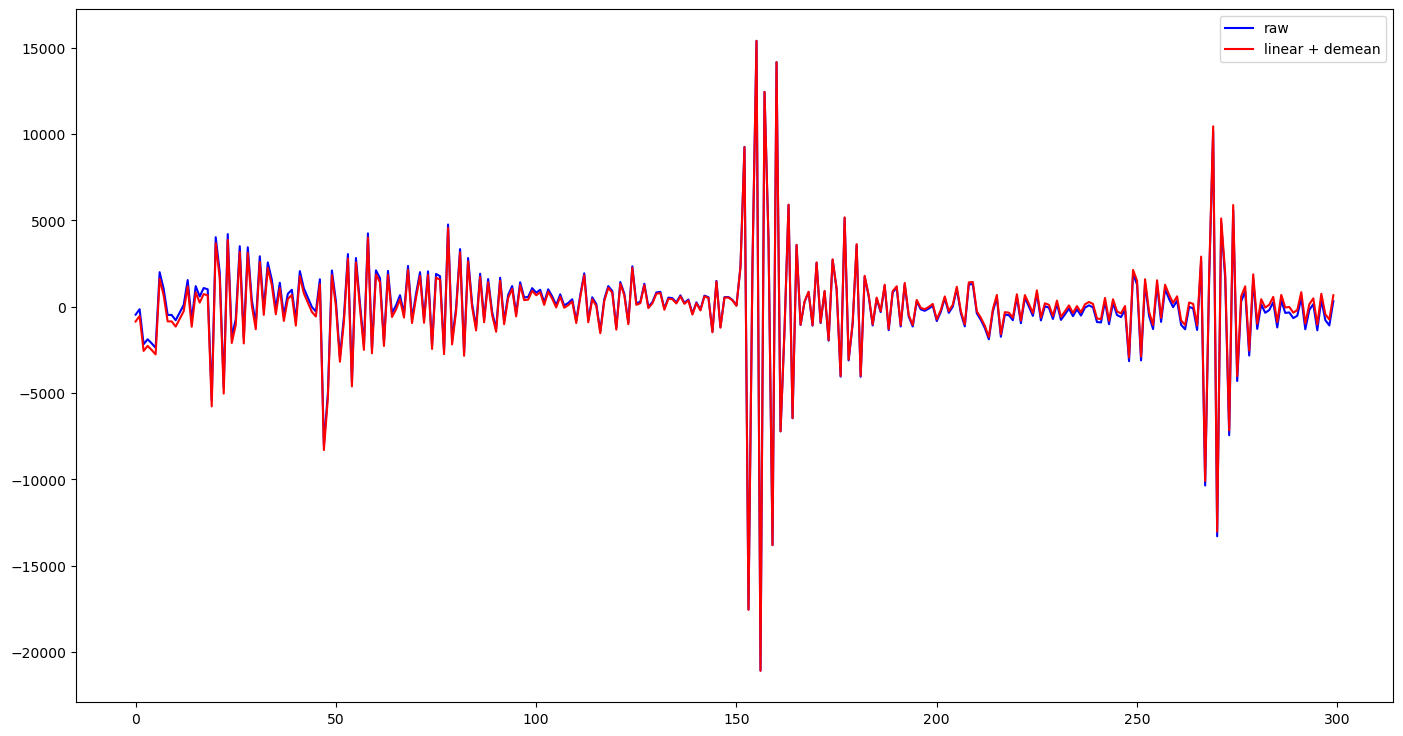

In [16]:
# detrend waveform
st_copy = st.copy()

st_detrend_linear = st_copy.detrend("linear")

st_detrend_mean = st_copy.detrend("demean")

st_detrend_combined = st_detrend_linear.detrend("demean")

plt.figure(figsize=(17,9))

# plot raw
for tr in st:
    data_raw = tr.data
plt.plot(data_raw,color='blue',label='raw')

# plot linear + mean
for tr in st_detrend_combined:
    data_combined = tr.data
plt.plot(data_combined,color='red',label="linear + demean")

plt.legend()

- taper smoothes the edges

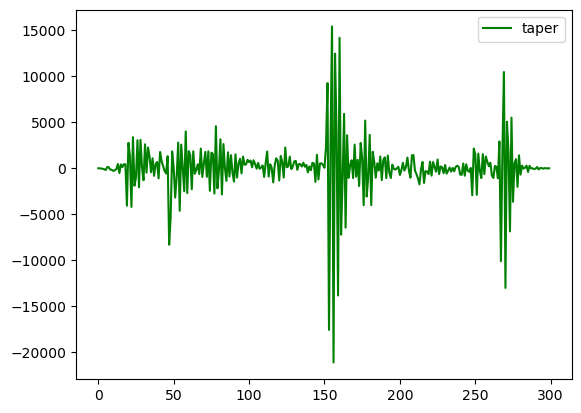

In [17]:
st_detrend_combined.taper(max(10.0 / st[0].stats.sampling_rate, 0.05))

for tr in st_detrend_combined:
    data_taper = tr.data
plt.plot(data_taper,color='green',label="taper")

plt.legend()

## What a low-pass filter does

**Preserves:**
Long-period signals (slow ground motion, broad waveforms)

**Suppresses:**
Short-period signals (sharp spikes, high-frequency noise)

In frequency space, everything above a chosen corner frequency is attenuated.

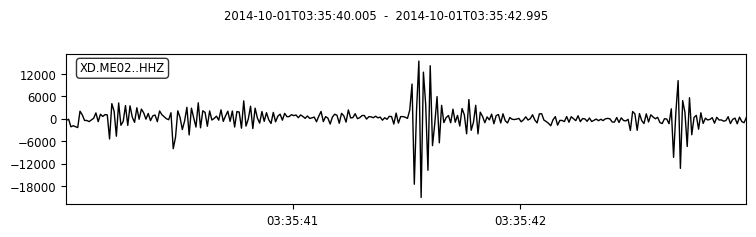

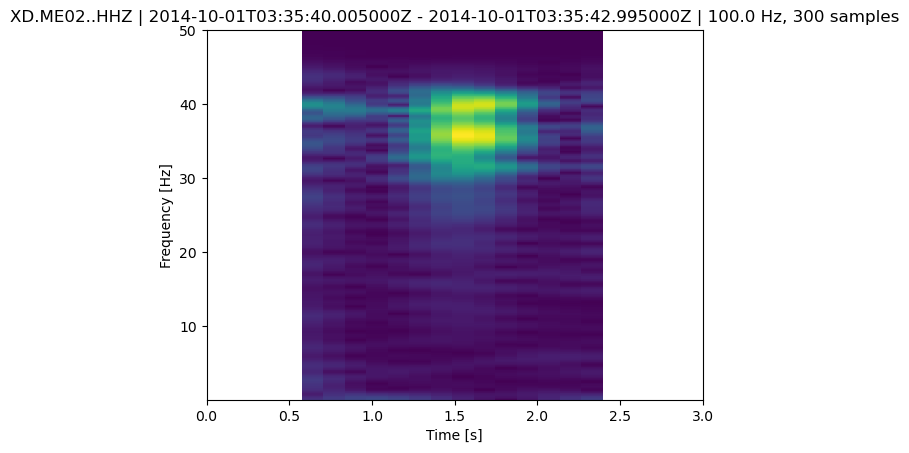

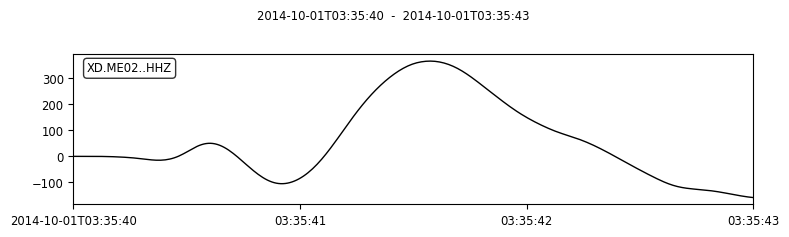

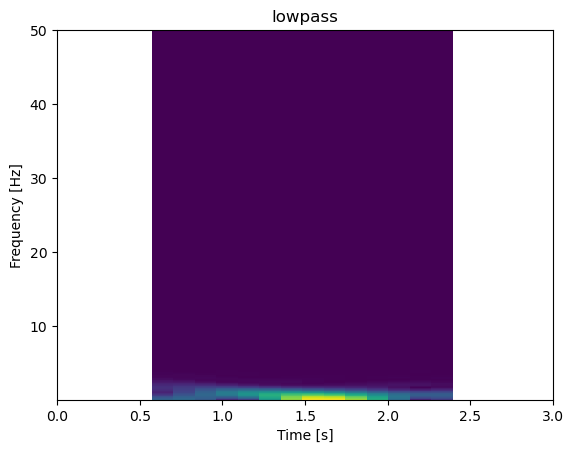

[None]

In [19]:
st.plot()
st.spectrogram()

st_lowpass = st_detrend_combined.copy()
st_lowpass.filter("lowpass",freq=1)
st_lowpass.plot(starttime=stt,endtime=edt)
st_lowpass.spectrogram(title='lowpass')

# st_process3.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)